# Data Cleaning and Processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
from sklearn.model_selection import train_test_split

C:\Users\gandh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Reading in the load data file

In [3]:
dmd_df = pd.read_csv("campusDemand.csv", parse_dates=["Time"])

In [4]:
try:
    dmd_df.drop(["Rendered", "Annotation"], inplace=True, axis=1)
except:
    pass
dmd_df["Time"] = pd.to_datetime(dmd_df["Time"])

## Rounding off to nearest hour

C:\Users\gandh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Timex,Value
0,2013-11-10 00:00:00,8261.731944
1,2013-11-10 01:00:00,8131.553229
2,2013-11-10 02:00:00,7985.570644
3,2013-11-10 03:00:00,7912.394148
4,2013-11-10 04:00:00,7857.923992


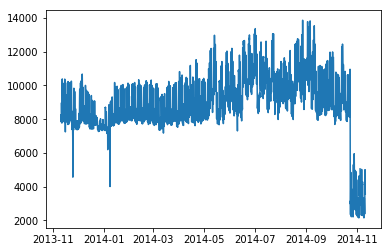

In [5]:
def roundhr(dt_time):
    dt_time = dt_time.replace(microsecond=0, second=0, minute=0)
    return dt_time

try:
    dmd_df.drop(["Rendered", "Annotation"], inplace=True, axis=1)
except:
    pass
dmd_df["Time"] = pd.to_datetime(dmd_df["Time"])
dmd_df.head(), dmd_df.dtypes

dmd_main = dmd_df[dmd_df["Point name"] == dmd_df["Point name"].unique()[5]]

dmd_main["Timex"] = dmd_main["Time"].apply(lambda x: roundhr(x))
dmd_main.head()
dmd_mainx = dmd_main.set_index(["Timex"])
dmd_mainx = dmd_mainx.resample("1H").mean()
dmd_mainx.reset_index(inplace=True)
plt.plot(dmd_mainx["Timex"], dmd_mainx["Value"])

dmd_mainx.head()

## Reading the  Weather data file

In [6]:
weatherdf = pd.read_csv("Weather_data_all.csv")
weatherdf = weatherdf.drop("Unnamed: 0", axis = 1)
weatherdf["Time"] = pd.to_datetime(weatherdf["Time"])
weatherdf.head()

,Time,Temp (F),Humidity,Wind Speed,Condition
0,2012-01-01 00:00:00,39.2,0.87,6.9,13.0
1,2012-01-01 01:00:00,39.2,0.87,3.5,13.0
2,2012-01-01 02:00:00,37.9,0.86,4.6,16.0
3,2012-01-01 03:00:00,37.0,0.89,3.5,0.0
4,2012-01-01 04:00:00,36.0,0.89,5.8,0.0


## Merging the weather and load data

In [7]:
dmd_mainx["Time"] = dmd_mainx["Timex"]
df = weatherdf.merge(dmd_mainx)
df.drop(["Timex"], axis=1, inplace=True)
df.head()

,Time,Temp (F),Humidity,Wind Speed,Condition,Value
0,2013-11-10 00:00:00,54.0,0.35,17.3,13.0,8261.731944
1,2013-11-10 01:00:00,53.1,0.41,20.7,12.0,8131.553229
2,2013-11-10 02:00:00,53.1,0.45,17.3,12.0,7985.570644
3,2013-11-10 03:00:00,51.1,0.48,12.7,14.0,7912.394148
4,2013-11-10 04:00:00,50.0,0.52,15.0,14.0,7857.923992


## Creating one hot vectors for weekdays and hour

In [8]:
df["Weekday"] = df["Time"].apply(lambda x: datetime.weekday(x))
new = np.asarray(df["Weekday"])
check = pd.get_dummies(new)
check.head()
df = df.join(check)
k = list(range(7))
v = list(map(str, k))
v = ["Weekday "+ a for a in v]
dic = zip(k, v)
dic = dict(dic)
dic
df.reset_index(inplace=True)
df = df.rename(dic, axis=1)

In [9]:
df['hours'] = df.Time.dt.hour
new = np.asarray(df["hours"])
check = pd.get_dummies(new)
check.head()
df = df.join(check)
k = list(range(24))
v = list(map(str, k))
v = ["Hour "+ a for a in v]
dic = zip(k, v)
dic = dict(dic)
df = df.rename(dic, axis='columns')
df.head()

,index,Time,Temp (F),Humidity,Wind Speed,Condition,Value,Weekday,Weekday 0,Weekday 1,...,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23
0,0,2013-11-10 00:00:00,54.0,0.35,17.3,13.0,8261.731944,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2013-11-10 01:00:00,53.1,0.41,20.7,12.0,8131.553229,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2013-11-10 02:00:00,53.1,0.45,17.3,12.0,7985.570644,6,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2013-11-10 03:00:00,51.1,0.48,12.7,14.0,7912.394148,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2013-11-10 04:00:00,50.0,0.52,15.0,14.0,7857.923992,6,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating Columns for past consumption data

In [10]:
for i in range(1, 169):
    new = [None]*i
    new = new + list(df["Value"])
    a = pd.Series(new.copy()[:len(df)])
    df["T"+str(-i)] = a
   
for i in range(1, 169):
    new = [None]*24
    new = new + list(df["T"+str(-i)])
    a = pd.Series(new.copy()[:len(df)])
    df["T"+str(-i)] = a

## Dropping Null Rows

In [11]:
df1 = df.dropna()

## Rearranging the dataset

In [12]:
nn1_l1 = []
for i in range(1, 169):
    tmp = ["T"+str(-i)]
    nn1_l1 = nn1_l1 + tmp.copy()

for i in range(24):
    tmp = ["Hour "+str(i)]
    nn1_l1 = nn1_l1 + tmp.copy()

for i in range(7):
    tmp = ["Weekday "+str(i)]
    nn1_l1 = nn1_l1 + tmp.copy()

nn1_l1 = nn1_l1 + ["Temp (F)"]

nn1_l1 = df1[nn1_l1]

out = df1[["Value"]]

nn1_l1.head()

,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9,T-10,...,Hour 22,Hour 23,Weekday 0,Weekday 1,Weekday 2,Weekday 3,Weekday 4,Weekday 5,Weekday 6,Temp (F)
192,8672.508489,8848.965995,8971.941948,9185.956123,9250.951042,9362.168974,9426.543421,9367.917952,9243.272519,9199.059827,...,0,0,1,0,0,0,0,0,0,60.1
193,8486.431955,8672.508489,8848.965995,8971.941948,9185.956123,9250.951042,9362.168974,9426.543421,9367.917952,9243.272519,...,0,0,1,0,0,0,0,0,0,57.9
194,8345.440925,8486.431955,8672.508489,8848.965995,8971.941948,9185.956123,9250.951042,9362.168974,9426.543421,9367.917952,...,0,0,1,0,0,0,0,0,0,55.0
195,8208.969043,8345.440925,8486.431955,8672.508489,8848.965995,8971.941948,9185.956123,9250.951042,9362.168974,9426.543421,...,0,0,1,0,0,0,0,0,0,52.0
196,8120.245189,8208.969043,8345.440925,8486.431955,8672.508489,8848.965995,8971.941948,9185.956123,9250.951042,9362.168974,...,0,0,1,0,0,0,0,0,0,51.1


## Splitting the dataset into train, test anf validation sets 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(nn1_l1, out, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=1)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5103, 200), (5103, 1), (1458, 200), (1458, 1), (730, 200), (730, 1))

In [15]:
X_train.head()

,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9,T-10,...,Hour 22,Hour 23,Weekday 0,Weekday 1,Weekday 2,Weekday 3,Weekday 4,Weekday 5,Weekday 6,Temp (F)
2581,9995.961852,9870.024985,9677.370785,9392.847138,8836.845375,8355.431338,8172.150171,8021.895442,8030.463140,8038.729246,...,0,0,0,1,0,0,0,0,0,25.0
7674,10734.847479,11108.219067,11260.804071,11230.603863,11117.825350,10974.387629,10878.715004,10210.686738,9669.849888,8994.760527,...,0,0,0,0,0,1,0,0,0,72.0
477,7823.656204,7823.364003,7868.414285,7883.308724,7747.102878,7640.463876,7607.537034,7622.953513,7587.855651,7534.597433,...,0,0,0,0,0,0,1,0,0,28.0
5220,8463.546600,8325.847346,8155.010012,8162.239642,8099.253806,8136.630915,8131.579498,8154.591408,8216.339717,8358.519904,...,0,0,0,0,0,0,0,0,1,73.9
1210,7330.407694,7340.382230,7387.772284,7429.839897,7419.429330,7387.274577,7397.377083,7395.188564,7446.858752,7483.295911,...,0,0,1,0,0,0,0,0,0,27.6


## Normalizing the dataset

In [16]:
X_train1 = np.asarray(X_train)[:, 0:168]/10000
X_train2 = np.asarray(X_train)[:, 168:200]
X_train2[:, 31] = X_train2[:, 31]/100
X_train1.shape, X_train2.shape


X_test1 = np.asarray(X_test)[:, 0:168]/10000
X_test2 = np.asarray(X_test)[:, 168:200]
X_test2[:, 31] = X_test2[:, 31]/100
X_test1.shape, X_test2.shape


X_val1 = np.asarray(X_val)[:, 0:168]/10000
X_val2 = np.asarray(X_val)[:, 168:200]
X_val2[:, 31] = X_val2[:, 31]/100

# y_train/=np.max(y_train)
# y_val/=np.max(y_val)
# y_test/=np.max(y_test)

X_val1.shape, X_val2.shape

((1458, 168), (1458, 32))

## Saving the dataset in directory

In [17]:
np.savetxt("X_train1.txt", X_train1)
np.savetxt("X_train2.txt", X_train2)
np.savetxt("X_val1.txt", X_val1)
np.savetxt("X_val2.txt", X_val2)
np.savetxt("X_test1.txt", X_test1)
np.savetxt("X_test2.txt", X_test2)
np.savetxt("y_train.txt", y_train)
np.savetxt("y_val.txt", y_val)
np.savetxt("y_test.txt", y_test)

Text(0,0.5,'Weekly Load (kWh)')

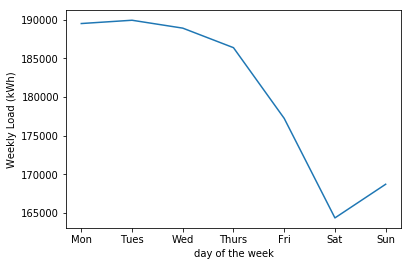

In [57]:
'value' in X_train.columns
# X_train = X_train.reset_index()
# X_train.groupby('Weekday')
# plt.plot(X_train.index, X_train['T-1'])
df = df.dropna()
# print(df.head())
plt.plot(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], df.groupby('Weekday').sum()['Value']/52)
y_label = 'Weekly Load (kWh)';x_label='day of the week'
plt.xlabel(x_label)
plt.ylabel(y_label)

Text(0,0.5,'Hourly Load (kWh)')

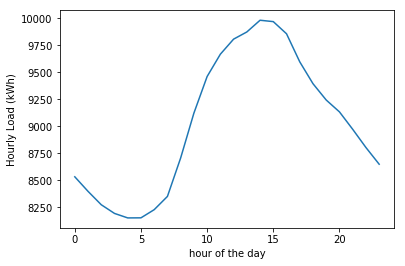

In [56]:
# df.groupby('hours').mean()
plt.plot(list(range(24)), df.groupby('hours').mean()['Value'])
y_label = 'Hourly Load (kWh)';x_label='hour of the day'
plt.xlabel(x_label)
plt.ylabel(y_label)

Text(0,0.5,'Monthly Load (kWh)')

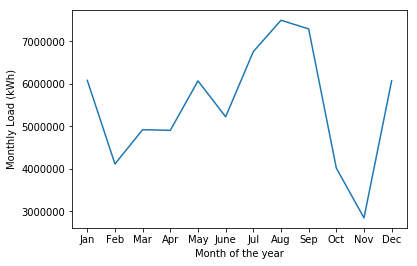

In [62]:
df['Months']=df['Time'].dt.month
plt.plot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], df.groupby('Months').sum()['Value'])
y_label = 'Monthly Load (kWh)';x_label='Month of the year'
plt.xlabel(x_label)
plt.ylabel(y_label)

Text(0,0.5,'Temperature (F)')

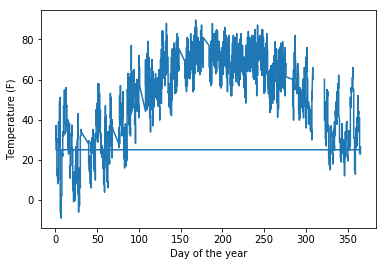

In [70]:
df['day of the year'] = df['Time'].dt.dayofyear
plt.plot(df['day of the year'], df['Temp (F)'])
y_label = 'Temperature (F)';x_label='Day of the year'
plt.xlabel(x_label)
plt.ylabel(y_label)